In [227]:
cd /home

/home


In [228]:
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import os

from src.data import pretraining_pipeline
from src.models import get_ASTROMER
from src.utils import get_metrics
import tomli

os.environ["CUDA_VISIBLE_DEVICES"] = '-1'

In [300]:
mask_frac = 20
lambda_pe = 0.5

path_ckpts = f'./presentation/experiments/astromer_0/results/macho_mask_{mask_frac}_{lambda_pe}/'
path_conf = f'./presentation/experiments/astromer_0/config_files/macho_mask_{mask_frac}_{lambda_pe}//alcock.100.f0.a.toml'
with open(path_conf, mode="rb") as fp:
    config = tomli.load(fp)     
path_ckpts

'./presentation/experiments/astromer_0/results/macho_mask_20_0.5/'

In [301]:
ft_metrics = pd.read_csv(os.path.join(path_ckpts, 'pretraining', 'metrics.csv'))

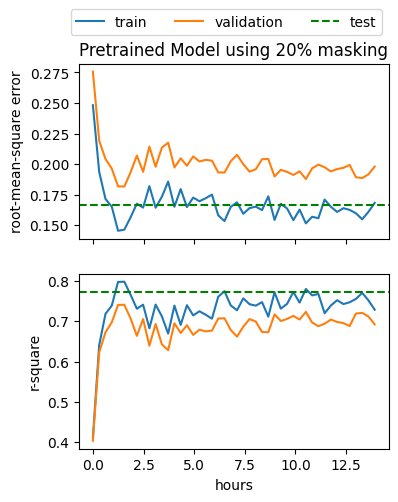

In [302]:
fig, axes = plt.subplots(2, 1, figsize=(4,5), sharex=True)

ft_name_metric = ['rmse', 'r_square']
titles = ['root-mean-square error', 'r-square']
for i, metric_name in enumerate(['epoch_loss', 'epoch_r_square']):
    val_logs = get_metrics(os.path.join(path_ckpts, 'pretraining', 'logs', 'validation'), 
                           show_keys=False, metric_name=metric_name)
    train_logs = get_metrics(os.path.join(path_ckpts, 'pretraining', 'logs', 'train'), 
                             show_keys=False, metric_name=metric_name)
    train_logs['wall_time'] = (train_logs['wall_time'] - train_logs['wall_time'].iloc[0])/(60*60)
    val_logs['wall_time'] = (val_logs['wall_time'] - val_logs['wall_time'].iloc[0])/(60*60)
    
    axes[i].plot(train_logs['wall_time'], train_logs['value'], label='train')
    axes[i].plot(val_logs['wall_time'], val_logs['value'], label='validation')
    test_rmse = ft_metrics[ft_metrics['step'] == 'pretraining'][ft_name_metric[i]].values
    
    axes[i].axhline(y=test_rmse, color='g', linestyle='--', label='test')
    axes[i].set_ylabel(titles[i])
axes[-1].set_xlabel('hours')
axes[0].set_title(f'Pretrained Model using {mask_frac}% masking')
axes[0].legend(bbox_to_anchor = (1., 1.35), ncol=3)
plt.show()

## Attention 

In [303]:
# LOADING DATA
BATCH_SIZE = 512
test_batches = pretraining_pipeline(os.path.join(config['finetuning']['data']['path'], 'test'),
                                    BATCH_SIZE,
                                    config['astromer']['window_size'],
                                    config['masking']['mask_frac'],
                                    config['masking']['rnd_frac'],
                                    config['masking']['same_frac'],
                                    config['pretraining']['data']['sampling'],
                                    config['pretraining']['data']['shuffle_test'],
                                    normalize=config['pretraining']['data']['normalize'],
                                    cache=config['pretraining']['data']['cache_test'])
test_data = test_batches.take(1)

[INFO] Repeating dataset x1 times


In [304]:
d_model = config['astromer']['head_dim']*config['astromer']['heads']
astromer =  get_ASTROMER(num_layers=config['astromer']['layers'],
                         d_model=d_model,
                         num_heads=config['astromer']['heads'],
                         dff=config['astromer']['dff'],
                         base=config['positional']['base'],
                         dropout=config['astromer']['dropout'],
                         maxlen=config['astromer']['window_size'],
                         pe_c=config['positional']['alpha'],
                         no_train=False)

astromer.load_weights(os.path.join(config['finetuning']['weights'], 'weights')).expect_partial()

PE_C RECEIVED:  tf.Tensor(0.5, shape=(), dtype=float32)


In [305]:
x_pred = astromer.predict(test_data)

In [306]:
x_true = tf.concat([y['target'] for _, y in test_data], 0)
x_time = tf.concat([x['times'] for x, _ in test_data], 0)
x_mask = tf.concat([y['mask_out'] for _, y in test_data], 0)

In [307]:
import numpy as np
from sklearn.metrics import r2_score

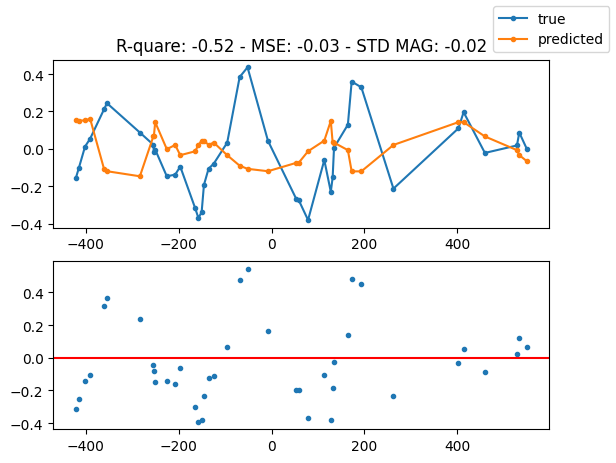

In [308]:
n = np.random.randint(0, len(x_true))

for i in range(n, n+1):
    fig, axes = plt.subplots(2, 1)
    curr_m = x_mask[i]
    curr_x = x_true[i]
    curr_y = x_pred[i]
    curr_t = x_time[i]
    
    curr_x_masked = tf.boolean_mask(curr_x, curr_m)
    curr_y_masked = tf.boolean_mask(curr_y, curr_m)
    curr_t_masked = tf.boolean_mask(curr_t, curr_m)
    
    residuals = curr_x_masked-curr_y_masked
    
    mse = np.mean(residuals)
    std_mag = np.mean(curr_x_masked)
    r2 = r2_score(curr_x, curr_y)
    
    axes[0].set_title('R-quare: {:.2f} - MSE: {:.2f} - STD MAG: {:.2f}'.format(r2, mse, std_mag))
    axes[0].plot(curr_t_masked, curr_x_masked, marker='.', label='true')
    axes[0].plot(curr_t_masked, curr_y_masked, marker='.', label='predicted')
    axes[1].plot(curr_t_masked, residuals, marker='.', linestyle='')
    axes[1].axhline(y=0., color='r', linestyle='-')

    fig.legend()

## Attention weights

In [309]:
# LOADING DATA
BATCH_SIZE = 512
print(config['finetuning']['data']['path'])
test_batches = pretraining_pipeline(os.path.join(config['finetuning']['data']['path'], 'test'),
                                    BATCH_SIZE,
                                    config['astromer']['window_size'],
                                    0.,
                                    0.,
                                    0.,
                                    config['pretraining']['data']['sampling'],
                                    config['pretraining']['data']['shuffle_test'],
                                    normalize=config['pretraining']['data']['normalize'],
                                    cache=config['pretraining']['data']['cache_test'])
test_data = test_batches.take(1)

./data/records/alcock/fold_0/alcock_100
[INFO] Repeating dataset x1 times


In [310]:
from bokeh.plotting import figure, output_file, show, output_notebook
from bokeh.models import ColumnDataSource, HoverTool, CustomJS
output_notebook()
    
def att_interactive_plot(x, y, att, title='light curve'):
    best_indices = np.argmax(att, 1)
    best_z = [z[best_indices[i]] for i, z in enumerate(att)]
    # Create a ColumnDataSource with our data
    source = ColumnDataSource(data=dict(x=x, y=y, values=best_indices, att_val=best_z, size=[10]*len(x)))

    # Create the plot
    p = figure(title=title, width=1000, height=250)
    p.line('x', 'y', source=source, line_width=2)
    c = p.circle('x', 'y', source=source, size='size', line_color=None, fill_alpha=0.5)

    hover_callback = CustomJS(args={'source': c}, code = """
        const indices = cb_data.index.indices
        
        console.log(source.value)
        """ )
    
    # Create a HoverTool to display the corresponding value when hovering over a data point
    hover = HoverTool(tooltips=[('Value', '@values'), ('Z', '@att_val')], 
                      mode='vline', callback=hover_callback)
    p.add_tools(hover)

    # Set the x-axis tick locations and labels
    p.xaxis.ticker = x[..., 0]
    p.xaxis.major_label_overrides = {float(tick): str(label) for tick, label in zip(x[...,0], np.arange(len(x)))}

    # Show the plot
    show(p)

Loading BokehJS ...

In [311]:
encoder = astromer.get_layer('encoder')

for x, y in test_data:
    output, weights = encoder(x, return_weights=True)    
#     index = np.random.randint(0, output.shape[0])
    index = 510
    curr_w = np.array(weights[index])
    curr_x = np.array(x['input'][index])
    curr_t = np.array(x['times'][index])
        
    indices_selected = np.random.random_integers(0, len(curr_x)-1, 200)
    indices_selected = np.sort(indices_selected)
    
    att_interactive_plot(curr_t[indices_selected], 
                         curr_x[indices_selected], 
                         att=curr_w[0][indices_selected])

/tmp/ipykernel_18120/108032794.py:11: DeprecationWarning: This function is deprecated. Please call randint(0, 199 + 1) instead
  indices_selected = np.random.random_integers(0, len(curr_x)-1, 200)


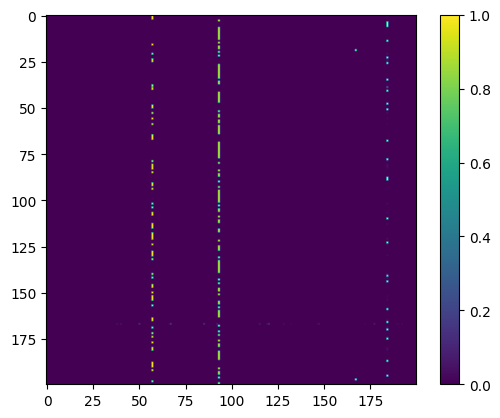

In [312]:
plt.imshow(curr_w[0])
plt.colorbar()

## Classification

In [313]:
clf_metrics = pd.read_csv(os.path.join(path_ckpts, 'alcock', 'classification','metrics.csv'))
clf_metrics[clf_metrics['sci_case'] == 'a']

,test_precision,test_recall,test_f1,val_acc,val_loss,model,time,fold,sci_case,spc,target
0,0.342276,0.346014,0.321764,0.375000,1.623477,mlp_last,2023-04-09 17:01:43,2,a,20,alcock
1,0.468336,0.473136,0.468854,0.562500,1.225774,lstm_att,2023-04-09 17:02:36,2,a,20,alcock
2,0.369726,0.290222,0.249297,0.343750,1.531787,mlp_first,2023-04-09 17:03:05,2,a,20,alcock
3,0.388410,0.385967,0.379202,0.500000,1.363693,lstm,2023-04-09 17:04:44,2,a,20,alcock
4,0.373418,0.371613,0.346097,0.458333,1.392964,mlp_att,2023-04-09 17:05:29,2,a,20,alcock
5,0.357079,0.361212,0.329125,0.500000,1.462662,mlp_last,2023-04-09 17:06:23,1,a,20,alcock
6,0.449890,0.447040,0.445200,0.625000,1.105482,lstm_att,2023-04-09 17:07:15,1,a,20,alcock
7,0.154917,0.238970,0.152527,0.416667,1.488974,mlp_first,2023-04-09 17:07:35,1,a,20,alcock
8,0.406190,0.383720,0.374727,0.552083,1.232905,lstm,2023-04-09 17:09:08,1,a,20,alcock
9,0.368534,0.375779,0.360335,0.489583,1.441616,mlp_att,2023-04-09 17:09:51,1,a,20,alcock


In [316]:
styles = {'mlp_att':{'marker':'^', 'linestyle':'-', 'name':'MLP+ATT'}, 
          'lstm_att':{'marker':'o', 'linestyle':'--', 'name':'LSTM+ATT'}, 
          'lstm':{'marker':'s', 'linestyle':':', 'name':'Baseline'},
          'mlp_att_conv':{'marker':'s', 'linestyle':':', 'name':'MLP+ATT+CONV'},
          'mlp_first':{'marker':'s', 'linestyle':':', 'name':'MLP+FIRST'},
          'mlp_last':{'marker':'v', 'linestyle':'-', 'name':'MLP+LAST'},
         }

ft_names_changed = {
    'alcock': 'MACHO', 'atlas': 'ATLAS', 'ogle':'OGLE-III'
}

Text(0.51, 0.05, 'Samples per class')

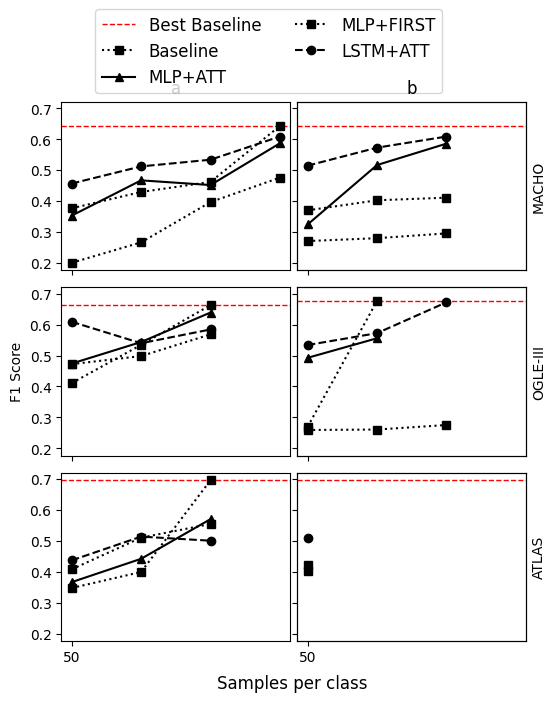

In [318]:
marker_models = ['s', '^', 'o', 'v']

fig, axes = plt.subplots(3, 2, sharey=True, sharex=True, figsize=(6,7), 
                         gridspec_kw={'hspace': 0.1, 'wspace': 0.03})
    
for row, target in enumerate(['alcock', 'ogle', 'atlas']):
    clf_metrics = pd.read_csv(os.path.join(path_ckpts, target, 'classification','metrics.csv'))
    
    best_baseline = []
    for col, sci_case in enumerate(['a', 'b']):
        
        if row == 0:
            axes[row][col].set_title(sci_case)
            
        for model_index, clf_model in enumerate(['lstm', 'mlp_att', 'mlp_first','lstm_att']):
            
            partial = clf_metrics[(clf_metrics['target'] == target) & \
                                  (clf_metrics['sci_case'] == sci_case) & \
                                  (clf_metrics['model'] == clf_model)]
            
            spc_cases, scores_mean, scores_std = [], [], []
            for spc, frame in partial.groupby('spc'):
                
                spc_cases.append(spc)
                scores_mean.append(frame['test_f1'].mean())
                scores_std.append(frame['test_f1'].std())
            
            x_range = np.arange(len(spc_cases))
            axes[row][col].errorbar(x_range, scores_mean, 
                               marker=styles[clf_model]['marker'], 
                               label=styles[clf_model]['name'],
                               linestyle=styles[clf_model]['linestyle'],
                               color='k')
            axes[row][col].set_xticks(x_range)
            axes[row][col].set_xticklabels([int(x) for x in spc_cases])
            
            
            if clf_model == 'lstm':
                best_baseline.append(np.max(scores_mean))
    
        axes[row][col].axhline(y=np.max(best_baseline), 
                               color='red', 
                               linestyle='--', 
                               linewidth=1, 
                               label='Best Baseline')
#         axes[row][col].set_yticks([round(x, 1) for x in np.linspace(0.1, 0.8, 10)])
    
        if col == 1:
            ax2 = axes[row][col].twinx()     
            ax2.set_yticks([])
            ax2.set_ylabel(ft_names_changed[target])

        

axes[1][0].set_ylabel('F1 Score')
axes[0][0].legend(ncol=2, bbox_to_anchor = (1.7, 1.6), fontsize=12)
fig.text(0.51, 0.05, 'Samples per class', ha='center', va='center', fontsize=12)